In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [79]:
stock = "GOLDBEES.NS"
data = yf.download(stock,'2022-08-01','2023-04-13')

[*********************100%***********************]  1 of 1 completed


In [80]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-01,44.439999,44.439999,43.830002,44.220001,44.220001,3672587
2022-08-02,44.490002,44.509998,44.009998,44.180000,44.180000,2404168
2022-08-03,44.180000,44.270000,43.910000,44.189999,44.189999,2213499
2022-08-04,44.480000,44.830002,43.930000,44.660000,44.660000,3192387
2022-08-05,44.959999,44.990002,44.369999,44.720001,44.720001,2218906
...,...,...,...,...,...,...
2023-04-05,51.799999,52.490002,51.750000,51.860001,51.860001,6683360
2023-04-06,51.639999,51.869999,51.560001,51.810001,51.810001,4684885
2023-04-10,51.680000,51.680000,51.110001,51.380001,51.380001,4825642


In [81]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df
adani_macd = get_macd(data['Close'],26,12,9)
adani_macd.tail()

,macd,signal,hist
Date,,,
2023-04-05,0.771379,0.617051,0.154327
2023-04-06,0.816925,0.657026,0.159899
2023-04-10,0.808997,0.687420,0.121577
2023-04-11,0.807128,0.711362,0.095766
2023-04-12,0.810027,0.731095,0.078932


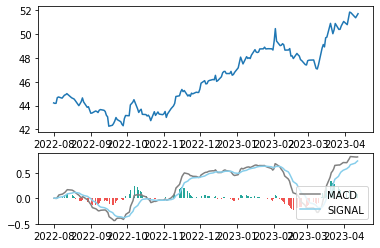

In [82]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((12,3), (0,0), rowspan = 7, colspan = 5)
    ax2 = plt.subplot2grid((12,3), (8,0), rowspan = 6, colspan = 5)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')
plot_macd(data['Close'], adani_macd['macd'], adani_macd['signal'], adani_macd['hist'])

In [83]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(data['Close'], adani_macd)

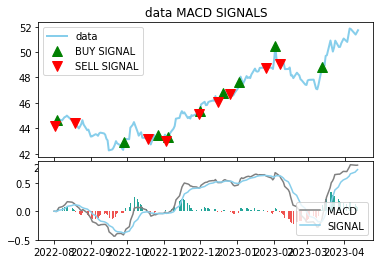

In [84]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['Close'], color = 'skyblue', linewidth = 2, label = 'data')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('data MACD SIGNALS')
ax2.plot(adani_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(adani_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(adani_macd)):
    if str(adani_macd['hist'][i])[0] == '-':
        ax2.bar(adani_macd.index[i], adani_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(adani_macd.index[i], adani_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [85]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = adani_macd['macd']
signal = adani_macd['signal']
close_price = data['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(data.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,macd,signal,macd_signal,macd_position
Date,,,,,
2022-08-01,44.220001,0.000000,0.000000,0,1
2022-08-02,44.180000,-0.003191,-0.000638,-1,0
2022-08-03,44.189999,-0.004857,-0.001482,0,0
2022-08-04,44.660000,0.031386,0.005092,1,1
2022-08-05,44.720001,0.064210,0.016915,0,1
...,...,...,...,...,...
2023-04-05,51.860001,0.771379,0.617051,0,1
2023-04-06,51.810001,0.816925,0.657026,0,1
2023-04-10,51.380001,0.808997,0.687420,0,1


In [86]:
from math import floor
from termcolor import colored as cl
adani_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(adani_ret)):
    try:
        returns = adani_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/data['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing 100k in ADANITRANS : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing 100k in ADANITRANS : 10468.41
Profit percentage of the MACD strategy : 10%
